In [1]:
# ---------------------------------------------------------------------
# Deep learning experiment (text-only) to predict log-standardized views
# - Load cleaned dataset
# - Tokenize free-text topic field (V11_general_topic)
# - Build small LSTM regression model
# - Train with EarlyStopping, evaluate (MSE, MAE, R2)
# - Save history, model, and plots
# ---------------------------------------------------------------------

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


In [ ]:
# -------- 1) Load data --------
df = pd.read_csv("tiktok_clean.csv")
df['M5_view_count_log_z'] = (df['M5_view_count_log'] - df['M5_view_count_log'].mean()) / df['M5_view_count_log'].std()
y = df['M5_view_count_log_z'].values


In [5]:
# -------- 2) Text length stats and tokenizer parameters --------
df['text_length'] = df['V11_general_topic'].apply(lambda x: len(str(x).split()))
max_len_in_data = int(df['text_length'].max())
mean_len = float(df['text_length'].mean())
print("Max tokens in text:", max_len_in_data)
print("Mean tokens in text:", mean_len)

# choose vocabulary size: small because texts are short and vocab is small
max_words = 500   # keep most frequent 500 words (adjust if you have much more vocab)

Max tokens in text: 18
Mean tokens in text: 5.030506721820062


In [6]:
# -------- 3) Tokenize & pad --------
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df['V11_general_topic'].astype(str))
sequences = tokenizer.texts_to_sequences(df['V11_general_topic'].astype(str))

# use the actual max length from the data to avoid unnecessary truncation/padding
max_len = max_len_in_data
X = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

print("Vocabulary size (tokenizer):", min(max_words, len(tokenizer.word_index)))
print("X shape:", X.shape)


Vocabulary size (tokenizer): 500
X shape: (3868, 18)


In [7]:
# -------- 4) Train/test split --------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

In [8]:
# -------- 5) Build small LSTM model --------
embedding_dim = 64

model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim),  # input_length no longer required
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(1, activation='linear')   # regression
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# -------- 6) Callbacks and training --------
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# save model and tokenizer
model.save("lstm_text_model.h5")
import json
with open("tokenizer.json", "w", encoding="utf-8") as f:
    f.write(tokenizer.to_json())


Epoch 1/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9968 - mae: 0.8398 - val_loss: 1.0154 - val_mae: 0.8510
Epoch 2/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.9939 - mae: 0.8383 - val_loss: 1.0194 - val_mae: 0.8501
Epoch 3/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.9403 - mae: 0.8085 - val_loss: 1.0194 - val_mae: 0.8418
Epoch 4/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8626 - mae: 0.7647 - val_loss: 1.0334 - val_mae: 0.8443
Epoch 5/30
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8365 - mae: 0.7502 - val_loss: 1.0266 - val_mae: 0.8414
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.


In [10]:
# -------- 7) Evaluation --------
y_pred = model.predict(X_test).flatten()
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Test R²: {r2:.4f}")
print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Test R²: -0.0002
Test MSE: 1.0154
Test MAE: 0.8510


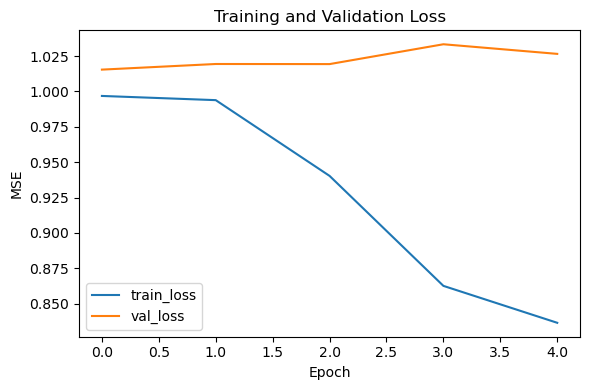

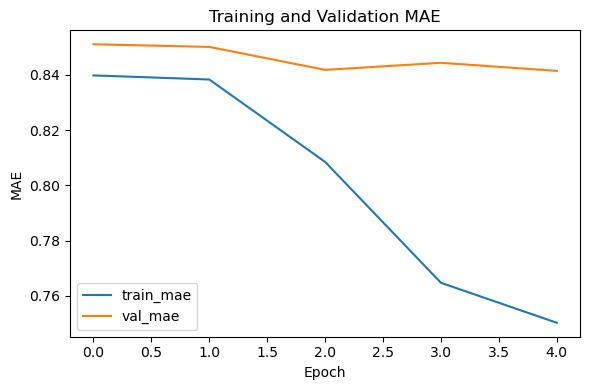

In [ ]:
# -------- 8) Training history plots --------
# Loss
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.title('Training and Validation Loss')
plt.tight_layout()
plt.savefig("lstm_loss.png", dpi=200)


# MAE
plt.figure(figsize=(6,4))
plt.plot(history.history['mae'], label='train_mae')
plt.plot(history.history['val_mae'], label='val_mae')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.title('Training and Validation MAE')
plt.tight_layout()
plt.savefig("lstm_mae.png", dpi=200)
